# Topic Map

In [5]:
import os
import pandas as pd
import re
import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')

transcription_dir_location_en = '../data/processed/transcription/en/'

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/frasercrichton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
docs = []

# from nltk.tokenize import sent_tokenize, word_tokenize
# sentences = [sent_tokenize(abstract) for abstract in abstracts]
# sentences = [sentence for doc in sentences for sentence in doc]

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location)
    transcription_text = transcriptions_df[0].iloc[0]
    
    # only analyse files with sentences with more then 27 words
    if len(transcription_text.split()) < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        # return
    
    # sentences = [sentence for sentence in sent_tokenize(transcription_text)]
    # print(sentences)
    sentence_list = sent_tokenize(transcription_text)
    for sentence in sentence_list:
        # if 'brothers' in sentence:
        #     print(sentence)   
        docs.append(sentence)
    # docs.append(' '.join(sentences))
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

# docs = list(filter(None, docs))
docs

['Another important chapter of our work in recent days concerns healthcare.', 'The government has allocated over one billion euros for Regions and autonomous provinces, to limit the impact of payback in medical devices, on companies in the sector and to strengthen emergency rooms.', 'Because the scenes of degradation, abandonment, confusion that we sometimes see in a difficult moment in our lives, that is, when we need emergency healthcare, are not tolerable.', 'So we decided to increase the salaries and overtime resources of emergency room doctors.', 'We have decided to limit the possibility that those who work in the public sector can easily and simultaneously also do so in the private sector, the so-called paid doctors.', 'And we have decided to introduce harsher penalties for those who attack healthcare workers.', 'Because it has also become intolerable that workers who do delicate and difficult work to save the lives of other people also have to fear for their own safety.', "Thank

['Another important chapter of our work in recent days concerns healthcare.',
 'The government has allocated over one billion euros for Regions and autonomous provinces, to limit the impact of payback in medical devices, on companies in the sector and to strengthen emergency rooms.',
 'Because the scenes of degradation, abandonment, confusion that we sometimes see in a difficult moment in our lives, that is, when we need emergency healthcare, are not tolerable.',
 'So we decided to increase the salaries and overtime resources of emergency room doctors.',
 'We have decided to limit the possibility that those who work in the public sector can easily and simultaneously also do so in the private sector, the so-called paid doctors.',
 'And we have decided to introduce harsher penalties for those who attack healthcare workers.',
 'Because it has also become intolerable that workers who do delicate and difficult work to save the lives of other people also have to fear for their own safety.',


1) Pre-calculate Embeddings

In [20]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

Stochastic Behaviour

In [21]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

Limit Number of Topics

In [22]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Improving Default Representation

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

In [45]:
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
openai.api_key=os.environ['openai_api_key'] 
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    # "KeyBERT": keybert_model,
    "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    "POS": pos_model
}

In [58]:

seed_topic_list = [['abortion'],
                   ['election', 'government', 'vote'],
                   ['bills', 'inflation'],
                   ['Italy', 'Italian']]


temp_topic_model = BERTopic(
  seed_topic_list= seed_topic_list,
  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  # hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,
  # min_topic_size=15
  # calculate_probabilities=False
)

topics, probs = temp_topic_model.fit_transform(docs, embeddings)
temp_topic_model.get_topic_info()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-10-02 21:52:40,573 - BERTopic - Reduced dimensionality
2023-10-02 21:52:40,624 - BERTopic - Clustered reduced embeddings


Topic  Count                                               Name  \
0      -1    862                       -1_people_say_government_don   
1       0    230                0_italy_italian_italians_government   
2       1    152                    1_italy_italian_italia_brothers   
3       2    104                           2_thank_ready_wait_happy   
4       3    104                3_ministers_nation_freedom_minister   
5       4     74                       4_price_bills_euros_thousand   
6       5     73              5_european_um_europe_european council   
7       6     48                 6_safety_emergency_work_protection   
8       7     47                    7_child_alternative_apply_women   
9       8     42                8_vote_electoral_campaign_elections   
10      9     38               9_government_proposal_abolish_ninety   
11     10     32                    10_resources_funds_fund_billion   
12     11     31                      11_realize_goals_study_decide   
13     12     30                  12_credits_credit_companies_banks   
14     13     29                    13_right_left_political_liberal   
15     14     29                     14_yes yes_yes_yes think_exact   
16     15     27                15_thank thank_thank_luck_good luck   
17     16     25           16_meloni_shivers_giorgia_giorgia meloni   
18     17     25            17_opposition_parliament_minister_party   
19     18     23                          18_ve heard_heard_ve_know   
20     19     23       19_cut_wedge_contribution_contribution wedge   
21     20     21            20_percent_leave_single allowance_euros   
22     21     21                 21_wage_minimum wage_minimum_legal   
23     22     21                       22_said_tell_thinks_don need   
24     23     20                    23_training_work_hiring_benefit   
25     24     20  24_income_citizenship income_citizenship_citiz...   
26     25     19                  25_young_young people_sports_kids   
27     26     19                 26_putin_values_christian_european   
28     27     18                27_state_just state_work_work level   
29     28     18                          28_okay_perfect_fine_good   
30     29     17           29_water_infrastructure_materials_events   
31     30     16                    30_measure_measures_badly_scams   
32     31     15                         31_petrol_price_gas_energy   
33     32     14       32_good news_interesting_unthinkable_complex   
34     33     13                33_morning_good_tired_early morning   
35     34     13                     34_christmas_scene_make_period   
36     35     12             35_desire_instability_decline_conflict   
37     36     11           36_thank_thanks thank_thanks_thank thank   
38     37     11  37_responsibility_time_day_assume responsibili...   

                                       Representation  \
0   [people, say, government, don, want, work, let...   
1   [italy, italian, italians, government, brother...   
2   [italy, italian, italia, brothers, fratelli it...   
3   [thank, ready, wait, happy, reality, thank pre...   
4   [ministers, nation, freedom, minister, council...   
5   [price, bills, euros, thousand, cash, average,...   
6   [european, um, europe, european council, counc...   
7   [safety, emergency, work, protection, homes, w...   
8   [child, alternative, apply, women, having, nin...   
9   [vote, electoral, campaign, elections, elector...   
10  [government, proposal, abolish, ninety, govern...   
11  [resources, funds, fund, billion, support, ini...   
12  [realize, goals, study, decide, tell, capable,...   
13  [credits, credit, companies, banks, longer, ha...   
14  [right, left, political, liberal, internal, co...   
15  [yes yes, yes, yes think, exact, huh, absolute...   
16  [thank thank, thank, luck, good luck, good, wo...   
17  [meloni, shivers, giorgia, giorgia meloni, let...   
18  [opposition, parliament, minister, party, demo...   
19  [ve heard, heard, v

In [59]:
fig = topic_model.visualize_topics(); fig

In [56]:
freq = temp_topic_model.get_topic_info(); 
freq.head(10)


Topic  Count                      Name  \
0     -1     41  -1_the_vote_of_electoral   
1      0   2079           0_the_to_of_and   
2      1    227         1_the_of_in_italy   

                                      Representation  \
0  [the, vote, of, electoral, to, they, you, in, ...   
1      [the, to, of, and, that, in, we, is, it, you]   
2   [the, of, in, italy, and, that, to, is, it, for]   

                                        OpenAI  \
0     [Electoral Voting in Campaign Elections]   
1  [Economic instability and national revival]   
2                     [Petrol prices in Italy]   

                                                 MMR  \
0  [the, vote, of, electoral, to, they, you, in, ...   
1      [the, to, of, and, that, in, we, is, it, you]   
2   [the, of, in, italy, and, that, to, is, it, for]   

                                                 POS  \
0  [electoral, campaign, elections, last, governm...   
1  [government, work, more, first, state, right, ...   
2  [euros, percent, bills, increase, years, year,...   

                                 Representative_Docs  
0  [Depending on how you are moving, your VAT num...  
1  [But we want a nation in which it is no longer...  
2  [I can announce to you now that the budget law...

In [17]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
# bm25_weighting=True, 
from bertopic.representation import PartOfSpeech
representation_model = PartOfSpeech("en_core_web_sm")

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

seed_topic_list = [['abortion'],
                   ['election', 'government', 'vote'],
                   ['bills', 'inflation'],
                   ['Italy', 'Italian']]
topic_model = BERTopic(ctfidf_model=ctfidf_model, seed_topic_list=seed_topic_list, representation_model=representation_model)
# topic_model = BERTopic(ctfidf_model=ctfidf_model, seed_topic_list=seed_topic_list)
topics, probs = topic_model.fit_transform(docs)

topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1   1032                    -1_government_people_more_years   
1       0    155                           0_sorry_enough_calm_cool   
2       1     77                     1_resources_funds_supply_water   
3       2     70                2_evening_splendid_happy_permission   
4       3     61                     3_cash_bills_inflation_evasion   
5       4     60          4_migration_trafficking_witch_traffickers   
6       5     47                 5_vote_electoral_campaign_election   
7       6     45               6_abortion_child_alternative_mothers   
8       7     45                  7_brothers_cross_award_tortellini   
9       8     39                8_ability_credible_cooperation_idol   
10      9     37        9_government_proposal_structured_opposition   
11     10     32                   10_goals_reality_destiny_capable   
12     11     31                11_sacrifices_homeland_proud_nation   
13     12     30                 12_pension_parental_pensions_euros   
14     13     28           13_salaries_subsidies_questioners_debtor   
15     14     28                        14_tones_book_story_methods   
16     15     27                               15_luck_thanks_work_   
17     16     26                    16_bonus_super_measure_measures   
18     17     26          17_income_citizenship_recipients_citizens   
19     18     25              18_safety_alternation_jobs_protection   
20     19     24            19_shivers_interested_stump_stereotypes   
21     20     24                      20_wedge_contribution_cut_tax   
22     21     22       21_ministers_minister_undersecretary_council   
23     22     22                   22_liberal_left_comparison_right   
24     23     22              23_parts_position_proud_deterioration   
25     24     21                    24_wage_minimum_parameter_legal   
26     25     20       25_parliament_opposition_confrontation_tough   
27     26     19                  26_sport_sports_youth_adolescence   
28     27     19                  27_credits_credit_banks_companies   
29     28     19                 28_training_hiring_work_assistance   
30     29     18                    29_values_part_communist_figure   
31     30     18                        30_ready_shirt_sushi_trophy   
32     31     17              31_brothers_elections_illiberal_party   
33     32     17                         32_welcome_fight_good_work   
34     33     17                       33_nativity_scene_trees_home   
35     34     16            34_interesting_journalism_exciting_news   
36     35     15                      35_state_just_fair_assistance   
37     36     14        36_responsibility_responsible_catwalks_time   
38     37     14                       37_price_petrol_gas_motorway   
39     38     13                     38_morning_good_tired_purposes   
40     39     12                      39_budget_law_provisions_bolt   
41     40     12               40_freedom_religious_democracy_value   
42     41     11          41_emergency_confusion_insecurity_eternal   
43     42     10            42_governance_patience_applause_clarity   
44     43     10  43_relations_collaboration_partnership_negotia...   

                                       Representation  \
0   [government, people, more, years, president, n...   
1   [sorry, enough, calm, cool, fine, shameful, cu...   
2   [resources, funds, supply, water, initiatives,...   
3   [evening, splendid, happy, permission, welcome...   
4   [cash, bills, inflation, evasion, bank, limit,...   
5   [migration, trafficking, witch, traffickers, h...   
6   [vote, electoral, campaign, election, republic...   
7   [abortion, child, alternative, mothers, birth,...   
8   [brothers, cross, award, tortellini, names, lo...   
9   [ability, credible, cooperation, idol, soft, t...   
10  [government, proposal, structured, opposition,...   
11  [goals, reality, destiny, capable, absurdity, ...

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# from hdbscan import HDBSCAN

# max_df=0.95, min_df=2, max_features=10, 
count_vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")
topic_model.update_topics(docs, vectorizer_model=count_vectorizer_model)
# topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1   1044                      -1_people_say_government_work   
1       0    358                  0_italy_italian_brothers_italians   
2       1     65              1_european_um_europe_european council   
3       2     60                2_resources_funds_water_initiatives   
4       3     51       3_electoral_vote_campaign_electoral campaign   
5       4     48                4_abortion_child_women_law abortion   
6       5     47                       5_work_today_tomorrow_result   
7       6     46                  6_bills_inflation_increase_energy   
8       7     36                7_safety_emergency_workers_politics   
9       8     33               8_realize_tell_capable_realize doing   
10      9     32                      9_yes_yes yes_yes yes yes_huh   
11     10     31                           10_say_tell_said_respect   
12     11     30            11_budget_budget law_wedge_contribution   
13     12     29  12_thank thank_thank_thank thank thank_thank good   
14     13     23                    13_right_left_political_liberal   
15     14     22                     14_meloni_shivers_giorgia_lets   
16     15     21  15_income_citizenship income_citizenship_citiz...   
17     16     20                       16_work_training_benefit_job   
18     17     20    17_minister_ministers_council_council ministers   
19     18     19                         18_ready_wait_dont let_let   
20     19     19                  19_credits_credit_companies_banks   
21     20     19                          20_heard bit_bit_heard_eh   
22     21     19            21_nation_proud_restore_day celebration   
23     22     19                 22_sport_young_young people_sports   
24     23     18    23_wage_minimum wage_minimum_legal minimum wage   
25     24     18          24_okay_okay good_perfect_okay thats fine   
26     25     17             25_russia_putin_values_european values   
27     26     17                      26_state_just state_work_just   
28     27     15                       27_price_petrol_average_euro   
29     28     14  28_christmas_nativity_nativity scene_make nati...   
30     29     14       29_unthinkable_interesting_good news_complex   
31     30     14  30_thank_thank thank_thank thank thank_thank t...   
32     31     14  31_ninetyfour_abolish_law ninetyfour_modify la...   
33     32     14    32_thank_president_thank president_good evening   
34     33     13          33_good morning_morning_good_morning good   
35     34     12          34_bonus_super_super bonus_ninety percent   
36     35     12                     35_measures_measure_scams_free   
37     36     12        36_percent_leave_single allowance_allowance   
38     37     11              37_government_level_opposition_matter   
39     38     11       38_pension_pensions_minimum_minimum pensions   
40     39     10  39_responsibility_time_work responsibility beg...   

                                       Representation  \
0   [people, say, government, work, know, want, do...   
1   [italy, italian, brothers, italians, brothers ...   
2   [european, um, europe, european council, counc...   
3   [resources, funds, water, initiatives, fund, m...   
4   [electoral, vote, campaign, electoral campaign...   
5   [abortion, child, women, law abortion, alterna...   
6   [work, today, tomorrow, result, day, moment, h...   
7   [bills, inflation, increase, energy, bank, mon...   
8   [safety, emergency, workers, politics, jobs, p...   
9   [realize, tell, capable, realize doing, point ...   
10  [yes, yes yes, yes yes yes, huh, yes huh, yes ...   
11  [say, tell, said, respect, dont need use, need...   
12  [budget, budget law, wedge, contribution, cont...   
13  [thank thank, thank, thank thank thank, thank ...   
14  [right, left, political, liberal, difference l...   
15  [meloni, shivers, giorgia, lets, derived, lets...   
16  [income, citizenship income, citizenship, citi..

In [110]:
topic_lables = topic_model.generate_topic_labels(nr_words=5, topic_prefix=False, word_length=15, separator=' - ')
topic_model.set_topic_labels(topic_lables)

# topic_model.set_topic_labels({14: "Abortion"})
topic_model.get_topic_info().head(20)

Topic  Count                        Name  \
0     -1     10   -1_hi_thanks_teachers_sir   
1      0   2269            0_the_to_of_that   
2      1     27       1_thank_you_luck_good   
3      2     24   2_sport_young_sports_kids   
4      3     17  3_thank_thanks_you_welcome   

                                    CustomName  \
0         hi - thanks - teachers - sir - hello   
1                   the - to - of - that - and   
2             thank - you - luck - good - work   
3  sport - young - sports - kids - desperately   
4        thank - thanks - you - welcome - much   

                                      Representation  \
0  [hi, thanks, teachers, sir, hello, join, ah, s...   
1      [the, to, of, that, and, in, is, we, it, for]   
2           [thank, you, luck, good, work, , , , , ]   
3  [sport, young, sports, kids, desperately, icel...   
4  [thank, thanks, you, welcome, much, very, too,...   

                                 Representative_Docs  
0                        [HI., HI., Hi, I can join.]  
1  [Furthermore, from my point of view, if you wa...  
2               [Thank you., Thank you., Thank you.]  
3  [I give the example of the small Iceland of An...  
4  [Thank you very much., Thank you very much to,...

In [67]:
topic_model.update_topics(docs, n_gram_range=(1, 3))
topic_model.get_topic_info().head(5)

Topic  Count                           Name  \
0     -1    877              -1_the_to_that_of   
1      0    456              0_the_of_italy_to   
2      1    122      1_we oh_or we oh_or we_oh   
3      2     56         2_we_work_ready_we are   
4      3     56  3_the_campaign_electoral_that   

                                         CustomName  \
0           work - people - say - government - know   
1  italy - italian - italians - european - brothers   
2                                    oh -  -  -  -    
3                ready - work - thank - job - think   
4   campaign - electoral - right - elections - left   

                                      Representation  \
0     [the, to, that, of, and, in, we, is, you, are]   
1    [the, of, italy, to, and, in, is, that, we, it]   
2       [we oh, or we oh, or we, oh, or, we, , , , ]   
3  [we, work, ready, we are, here, you, are, to, ...   
4  [the, campaign, electoral, that, right, is, th...   

                                 Representative_Docs  
0  [ But what priorities did you set with the fir...  
1  [ This instability has produced our economic w...  
2                                       [we, Oh, or]  
3  [ It's the reason we are here today, so thank ...  
4  [ Meanwhile, we vote on one day only, Sunday t...

In [68]:
# merge topics
topic_model.merge_topics(docs, topics_to_merge=[-1, 1])
topic_model.get_topic_info().head(5)

Topic  Count                           Name  \
0     -1    999              -1_the_to_that_of   
1      0    456              0_the_of_italy_to   
2      1     56         1_we_work_ready_we are   
3      2     56  2_the_campaign_electoral_that   
4      3     53     3_we_you_responsibility_is   

                                      Representation  \
0     [the, to, that, of, and, in, we, is, you, are]   
1    [the, of, italy, to, and, in, is, that, we, it]   
2  [we, work, ready, we are, here, you, are, to, ...   
3  [the, campaign, electoral, that, right, is, th...   
4  [we, you, responsibility, is, to, this, and, t...   

                                 Representative_Docs  
0  [ I can announce to you now that the budget la...  
1  [ Easy it doesn't take much you have to study,...  
2  [ And obviously we are already announcing that...  
3  [ I am potentially the majority now, will I de...  
4  [ So the higher we climb and the more we bring...

In [69]:
#reduce number of topics
topic_model.reduce_topics(docs, 15)
topic_model.get_topic_info().head(15)


Topic  Count                                            Name  \
0      -1    999                               -1_the_to_of_that   
1       0   1022                                 0_the_to_of_and   
2       1     43                               1_the_to_for_that   
3       2     37       2_thank you_thank_you thank you_you thank   
4       3     32                         3_hi_hi hi_hi hi hi_mrs   
5       4     29                 4_wage_minimum_minimum wage_the   
6       5     28     5_income_citizenship income_citizenship_the   
7       6     28             6_meloni_shivers_letta_enrico letta   
8       7     21                  7_christmas_home_nativity_make   
9       8     15                    8_yes_yes yes_no_yes yes yes   
10      9     15                     9_cash_cash limit_the_limit   
11     10     14                  10_okay_okay good_perfect_good   
12     11     14  11_morning_good morning_good_good morning good   
13     12     12             12_pension_pensions_hundred_minimum   
14     13     10   13_enough_filling_the filling_put the filling   

                                       Representation  \
0      [the, to, of, that, and, in, we, is, you, are]   
1       [the, to, of, and, that, in, is, we, it, for]   
2   [the, to, for, that, is, of, abortion, one hun...   
3   [thank you, thank, you thank you, you thank, t...   
4   [hi, hi hi, hi hi hi, mrs, mr hi, yo hi hi, hi...   
5   [wage, minimum, minimum wage, the, that, is, i...   
6   [income, citizenship income, citizenship, the,...   
7   [meloni, shivers, letta, enrico letta, enrico,...   
8   [christmas, home, nativity, make, nativity sce...   
9   [yes, yes yes, no, yes yes yes, no yes, mhm, n...   
10  [cash, cash limit, the, limit, evasion, the ca...   
11  [okay, okay good, perfect, good, right, perfec...   
12  [morning, good morning, good, good morning goo...   
13  [pension, pensions, hundred, minimum, minimum ...   
14  [enough, filling, the filling, put the filling...   

                                  Representative_Docs  
0   [ And obviously in many cases let's say the ov...  
1   [ From the extension of the Solidarity Fund fo...  
2   [ The um measures for the facilitation of the ...  
3   [ Thank you,  Thank you,  Thank you very much ...  
4                                     [ HI,  HI,  HI]  
5   [ Look, what I want to do is simply give a sig...  
6   [ According to data from the scientific evalua...  
7   [ I consider it shameful that Enrico Letta doe...  
8   [ Don't make this symbolic gesture of being he...  
9                [Yes,  Yes, yes again,  Yes Yes Yes]  
10  [ We decided to introduce a forty percent tax ...  
11  [ Okay,  So you see, I want to be clear,  Okay...  
12      [ Good morning,  Good morning,  Good morning]  
13  [ We wanted to strengthen the State's attentio...  
14  [ They put the filling,  After that you need t...

In [72]:
# find topics
topic_model.find_topics("minimum wage", top_n=1)

([4], [0.811109652543362])

In [ ]:

# %%time
# model = BERTopic(
#     n_gram_range=(1, 2),
#     vectorizer_model=vectorizer_model,
#     nr_topics='auto',
#     min_topic_size=10,
#     diversity=0.7,
#     seed_topic_list=[
#         ["experience", "bad", "good", "nice"],
#         ["place", "atmosphere", "toilet", "clean"],
#         ["staff", "waitress", "service"],
#         ["wait", "time", "long"],
#         ["food", "taste"]
#     ],
#     calculate_probabilities=True).fit(docs, corpus_embeddings)
# remove outliers
#  Comment out this line below if you decided to use the "propbabilities" strategy
# new_topics = model.reduce_outliers(docs, topics, strategy="c-tf-idf")


# Reduce outliers using the `probabilities` strategy (Uncomment to use this)
# #new_topics = model.reduce_outliers(docs, topics, probabilities=probabilities, strategy="probabilities")
# This line is to update the model with the latest topic assignment 
# model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model)

# df_topic_freq = model.get_topic_freq()
# topics_count = len(df_topic_freq) - 1
# df_topic_freq

In [29]:
topic_model.get_topic(1, full=True)

{'Main': [('resources', 0.34233379948596654),
  ('funds', 0.3032718741004985),
  ('supply', 0.26264114722434767),
  ('water', 0.23409891594143203),
  ('initiatives', 0.23409891594143203),
  ('sustainability', 0.2223248573316655),
  ('chains', 0.2223248573316655),
  ('fund', 0.2164697369102441),
  ('interventions', 0.2144455987196154),
  ('sector', 0.2096279744849494)]}

In [10]:
topic_model.get_document_info(docs)

Document  Topic  \
0     Another important chapter of our work in recen...     -1   
1     The government has allocated over one billion ...      2   
2     Because the scenes of degradation, abandonment...      7   
3     So we decided to increase the salaries and ove...     -1   
4     We have decided to limit the possibility that ...     -1   
...                                                 ...    ...   
2342  Yesterday established a principle, namely that...     -1   
2343  The approach of the European Council in the co...      1   
2344  The approach that the European Council, um put...      1   
2345  Immigration is a European problem and needs a ...      1   
2346  This, from my point of view, changes many thin...      1   

                                       Name  \
0             -1_people_say_government_work   
1       2_resources_funds_water_initiatives   
2       7_safety_emergency_workers_politics   
3             -1_people_say_government_work   
4             -1_people_say_government_work   
...                                     ...   
2342          -1_people_say_government_work   
2343  1_european_um_europe_european council   
2344  1_european_um_europe_european council   
2345  1_european_um_europe_european council   
2346  1_european_um_europe_european council   

                                         Representation  \
0     [people, say, government, work, know, want, do...   
1     [resources, funds, water, initiatives, fund, m...   
2     [safety, emergency, workers, politics, jobs, p...   
3     [people, say, government, work, know, want, do...   
4     [people, say, government, work, know, want, do...   
...                                                 ...   
2342  [people, say, government, work, know, want, do...   
2343  [european, um, europe, european council, counc...   
2344  [european, um, europe, european council, counc...   
2345  [european, um, europe, european council, counc...   
2346  [european, um, europe, european council, counc...   

                                    Representative_Docs  \
0     [For me now the priority is to confirm those m...   
1     [For this reason, the objective of our work mu...   
2     [our work is a work that will see the Minister...   
3     [For me now the priority is to confirm those m...   
4     [For me now the priority is to confirm those m...   
...                                                 ...   
2342  [For me now the priority is to confirm those m...   
2343  [This means firmly combating illegal immigrati...   
2344  [This means firmly combating illegal immigrati...   
2345  [This means firmly combating illegal immigrati...   
2346  [This means firmly combating illegal immigrati...   

                                            Top_n_words  Probability  \
0     people - say - government - work - know - want...     0.000000   
1     resources - funds - water - initiatives - fund...     0.809478   
2     safety - emergency - workers - politics - jobs...     0.973632   
3     people - say - government - work - know - want...     0.000000   
4     people - say - government - work - know - want...     0.000000   
...                                                 ...          ...   
2342  people - say - government - work - know - want...     0.000000   
2343  european - um - europe - european council - co...     1.000000   
2344  european - um - europe - european council - co...     1.000000   
2345  european - um - europe - european council - co...     0.930068   
2346  european - um - europe - european council - co...     0.890184   

      Representative_document  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False  
...                       ...  
2342                    False  
2343                    False  
2344                    False  
2345                    False  
2346                    False  

[2347 rows x 8 column

In [11]:
topic_model.visualize_barchart(width=280, height=330, top_n_topics=40, n_words=10)

In [164]:
topic_model.visualize_heatmap(n_clusters=10)

In [165]:
topic_model.hierarchical_topics(docs)

# semi supervised topics model
# topic_model.fit(docs, y = y)

# incremental topic modelling
# topic_model.partial_fit(docs)

# Dynamci topics topics over time
# topic_model.topics_over_time(docs, timestamps=)

# class based topic modelling
# topic_model.topics_per_class(docs, classes)


100%|██████████| 47/47 [00:00<00:00, 247.96it/s]


Parent_ID                                        Parent_Name  \
46        94                  italy_say_work_italian_government   
45        93                  italy_say_work_italian_government   
44        92                  italy_say_italian_work_government   
43        91                  italy_say_italian_work_government   
42        90                    italy_italian_say_government_um   
41        89               italy_italian_government_um_european   
40        88              minimum_wage_minimum wage_percent_law   
39        87              yes_yes yes_good_good morning_morning   
38        86                       meloni_say_dont_cash_freedom   
37        85               italy_italian_european_government_um   
36        84                     meloni_say_dont_electoral_said   
35        83           cash_freedom_christmas_green pass_people   
34        82                  budget_law_bonus_budget law_super   
33        81            freedom_christmas_green pass_green_pass   
32        80                   cash_cash limit_rape_limit_video   
31        79          minimum_wage_minimum wage_percent_pension   
30        78       good morning_morning_good_ready_morning good   
29        77                         say_dont_realize_said_tell   
28        76                rape_video_victim_filling_ukrainian   
27        75                  green pass_green_pass_women_moved   
26        74         italy_italian_european_italians_government   
25        73                  cash_cash limit_limit_choice_bank   
24        72         freedom_christmas_sport_young_young people   
23        71               green pass_green_pass_women_abortion   
22        70                    yes_yes yes_russia_putin_values   
21        69      meloni_electoral_left_vote_electoral campaign   
20        68       ministers_day_work_council ministers_council   
19        67            freedom_sport_young_young people_people   
18        66           bonus_super_super bonus_measure_measures   
17        65           credits_credit_resources_companies_funds   
16        64   income_work_state_citizenship income_citizenship   
15        63       ministers_work_council ministers_council_day   
14        62           italy_italian_european_italians_brothers   
13        61           budget_law_budget law_abolish_ninetyfour   
12        60     percent_bills_leave_increased_single allowance   
11        59       meloni_vote_electoral_giorgia_giorgia meloni   
10        58                    yes_yes yes_russia_putin_values   
9         57   income_work_state_citizenship income_citizenship   
8         56   ministers_council ministers_council_minister_day   
7         55  good morning_morning_good_morning good_good mo...   
6         54         minimum_wage_minimum wage_pension_pensions   
5         53                       say_dont_tell_look_look dont   
4         52              state_work_just state_create_training   
3         51           italy_italian_european_italians_brothers   
2         50  thank_thank thank_thank thank thank_good_presi...   
1         49               cut_wedge_tax_thousand euros_incomes   
0         48  thank_thank thank_thank thank thank_thank good...   

                                               Topics Child_Left_ID  \
46  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...            50   
45  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...            92   
44  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...            87   
43  [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...            90   
42  [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 1...            86   
41  [0, 2, 5, 6, 8, 12, 13, 15, 18, 20, 27, 28, 32...            85   
40                   [12, 18, 27, 28, 32, 44, 45, 47]            79   
39                            [3, 22, 25, 26, 35, 40]            78   
38  [1, 4, 9, 10, 11, 16, 19, 24, 30, 31, 36, 37, ...            83   
37                    [0, 2, 5, 6, 8, 13, 15, 20, 38]            68   
36   

In [12]:
topic_model.visualize_topics()

In [13]:

from umap import UMAP

from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [32]:
doc_id = 41
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

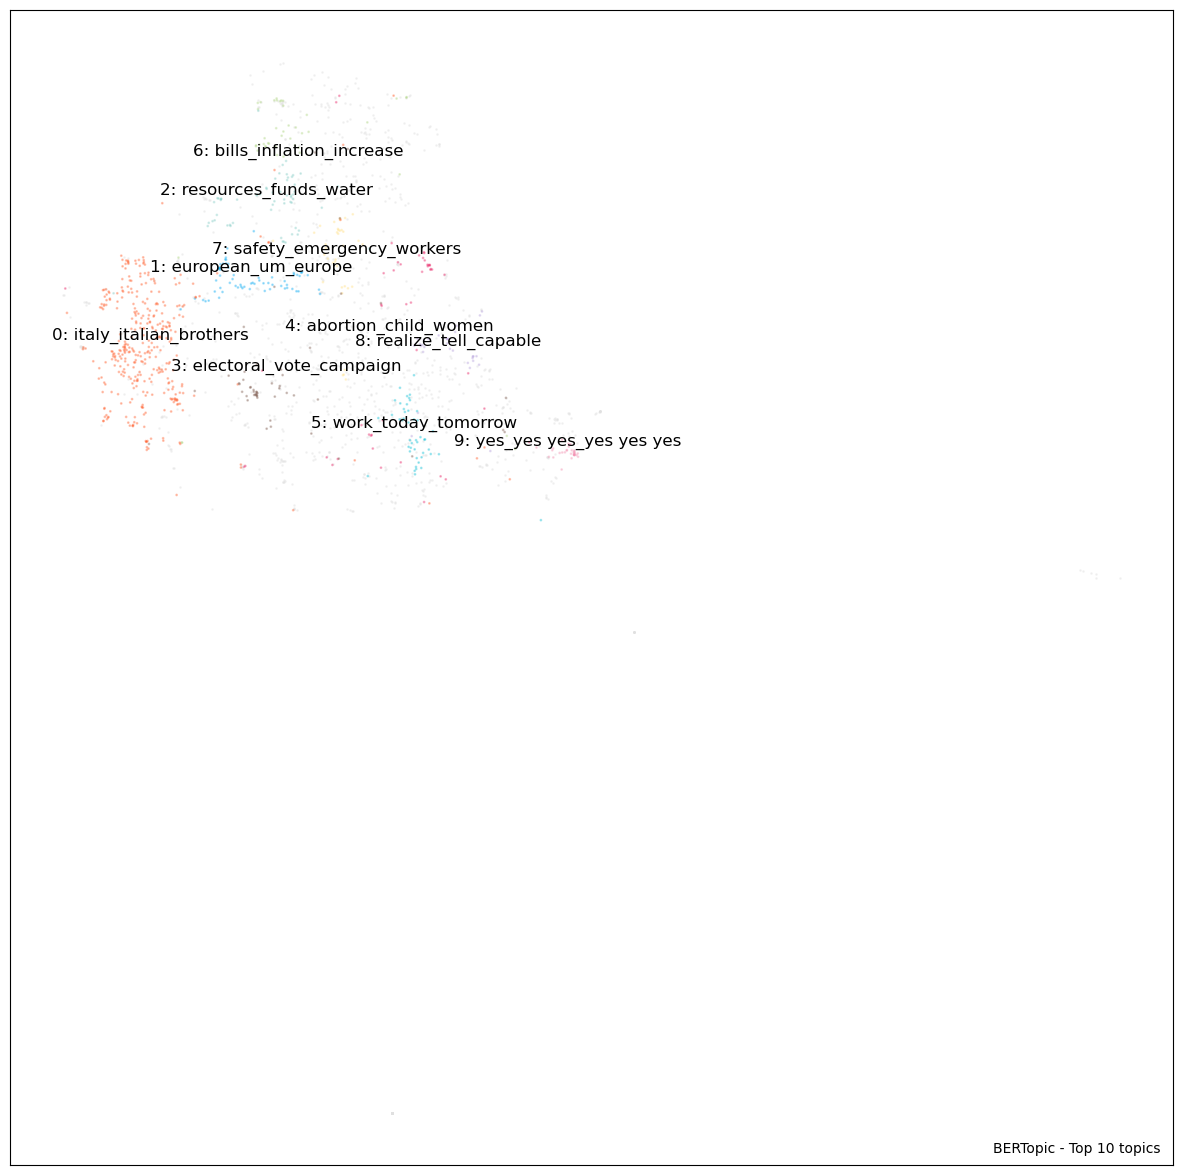

In [16]:
import matplotlib
import matplotlib.pyplot as plt

# Prepare data for plotting
embeddings = topic_model._extract_embeddings(docs, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

# Plot parameters
top_n = 10
fontsize = 12

# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                         '#03A9F4', # Blue
                                         '#4CAF50', # Green
                                         '#80CBC4', # FFEB3B
                                         '#673AB7', # Purple
                                         '#795548', # Brown
                                         '#E91E63', # Pink
                                         '#212121', # Black
                                         '#00BCD4', # Light Blue
                                         '#CDDC39', # Yellow/Red
                                         '#AED581', # Light Green
                                         '#FFE082', # Light Orange
                                         '#BCAAA4', # Light Brown
                                         '#B39DDB', # Light Purple
                                         '#F48FB1', # Light Pink
                                         ])

# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
    topic = int(row[1].topic)
    text = f"{topic}: " + "_".join([x[0] for x in topic_model.get_topic(topic)[:3]])
    ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

Loading dataset...
done in 0.004s.
Extracting tf-idf features for NMF...
done in 0.032s.
Extracting tf features for LDA...
done in 0.024s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.163s.


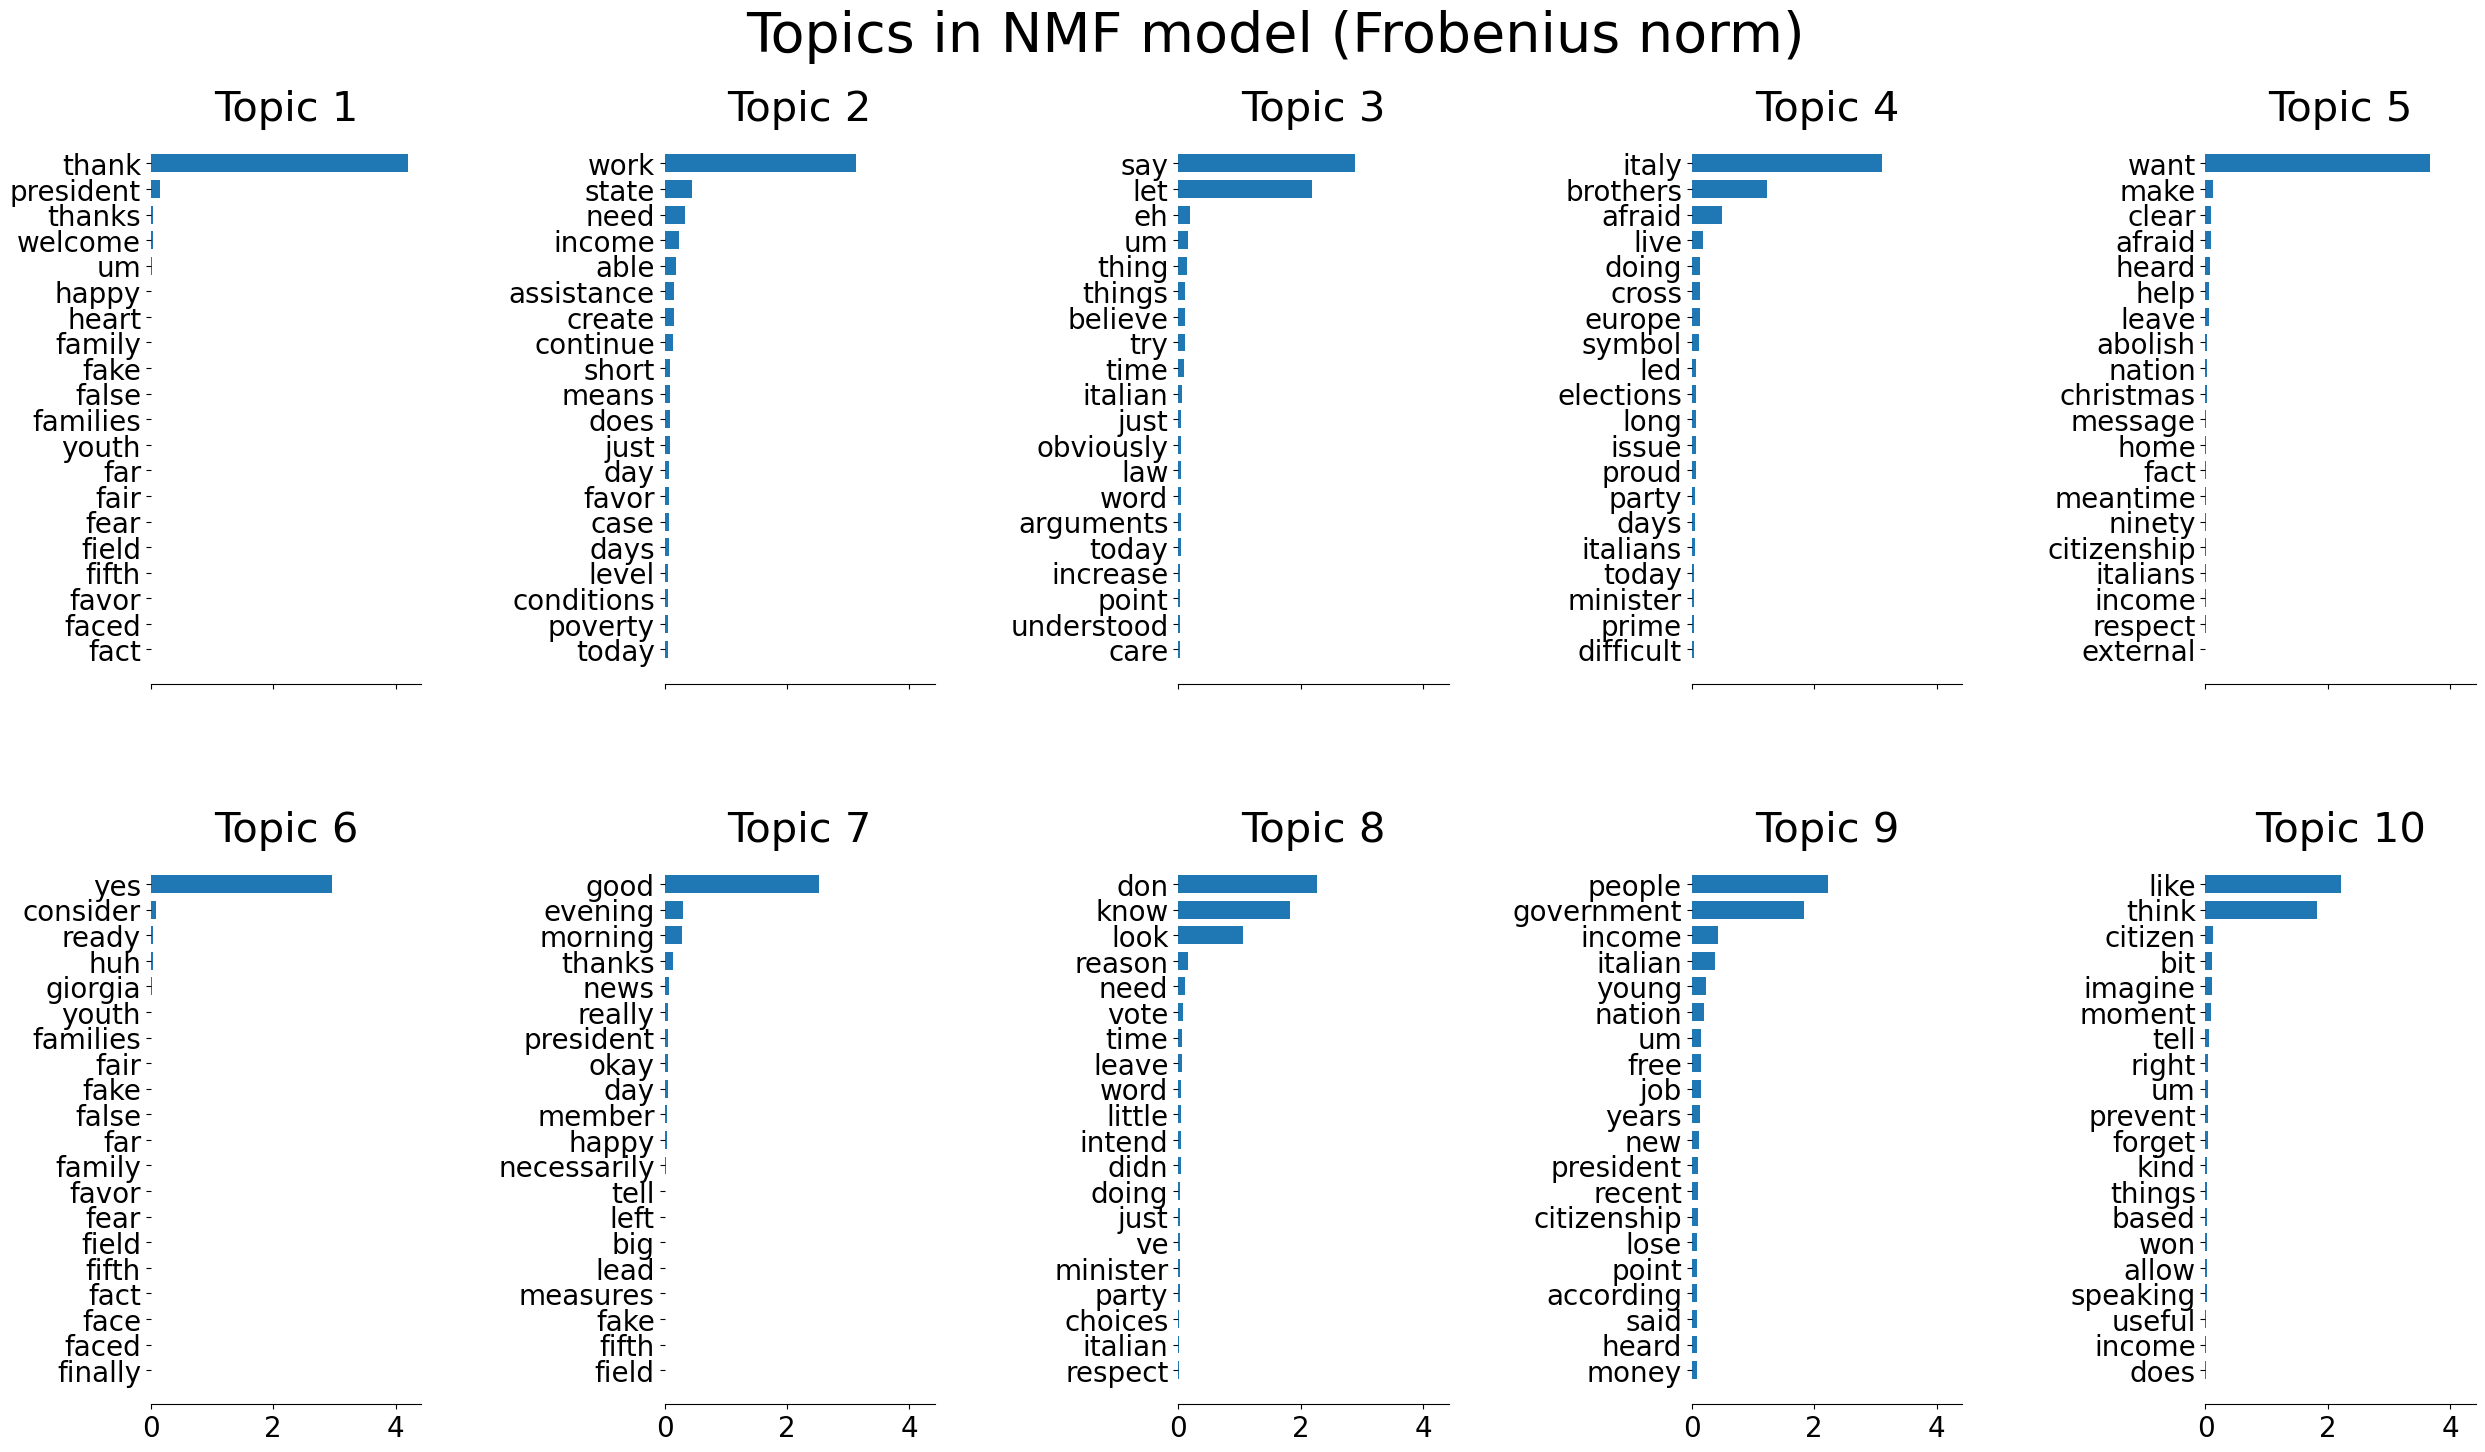



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.638s.


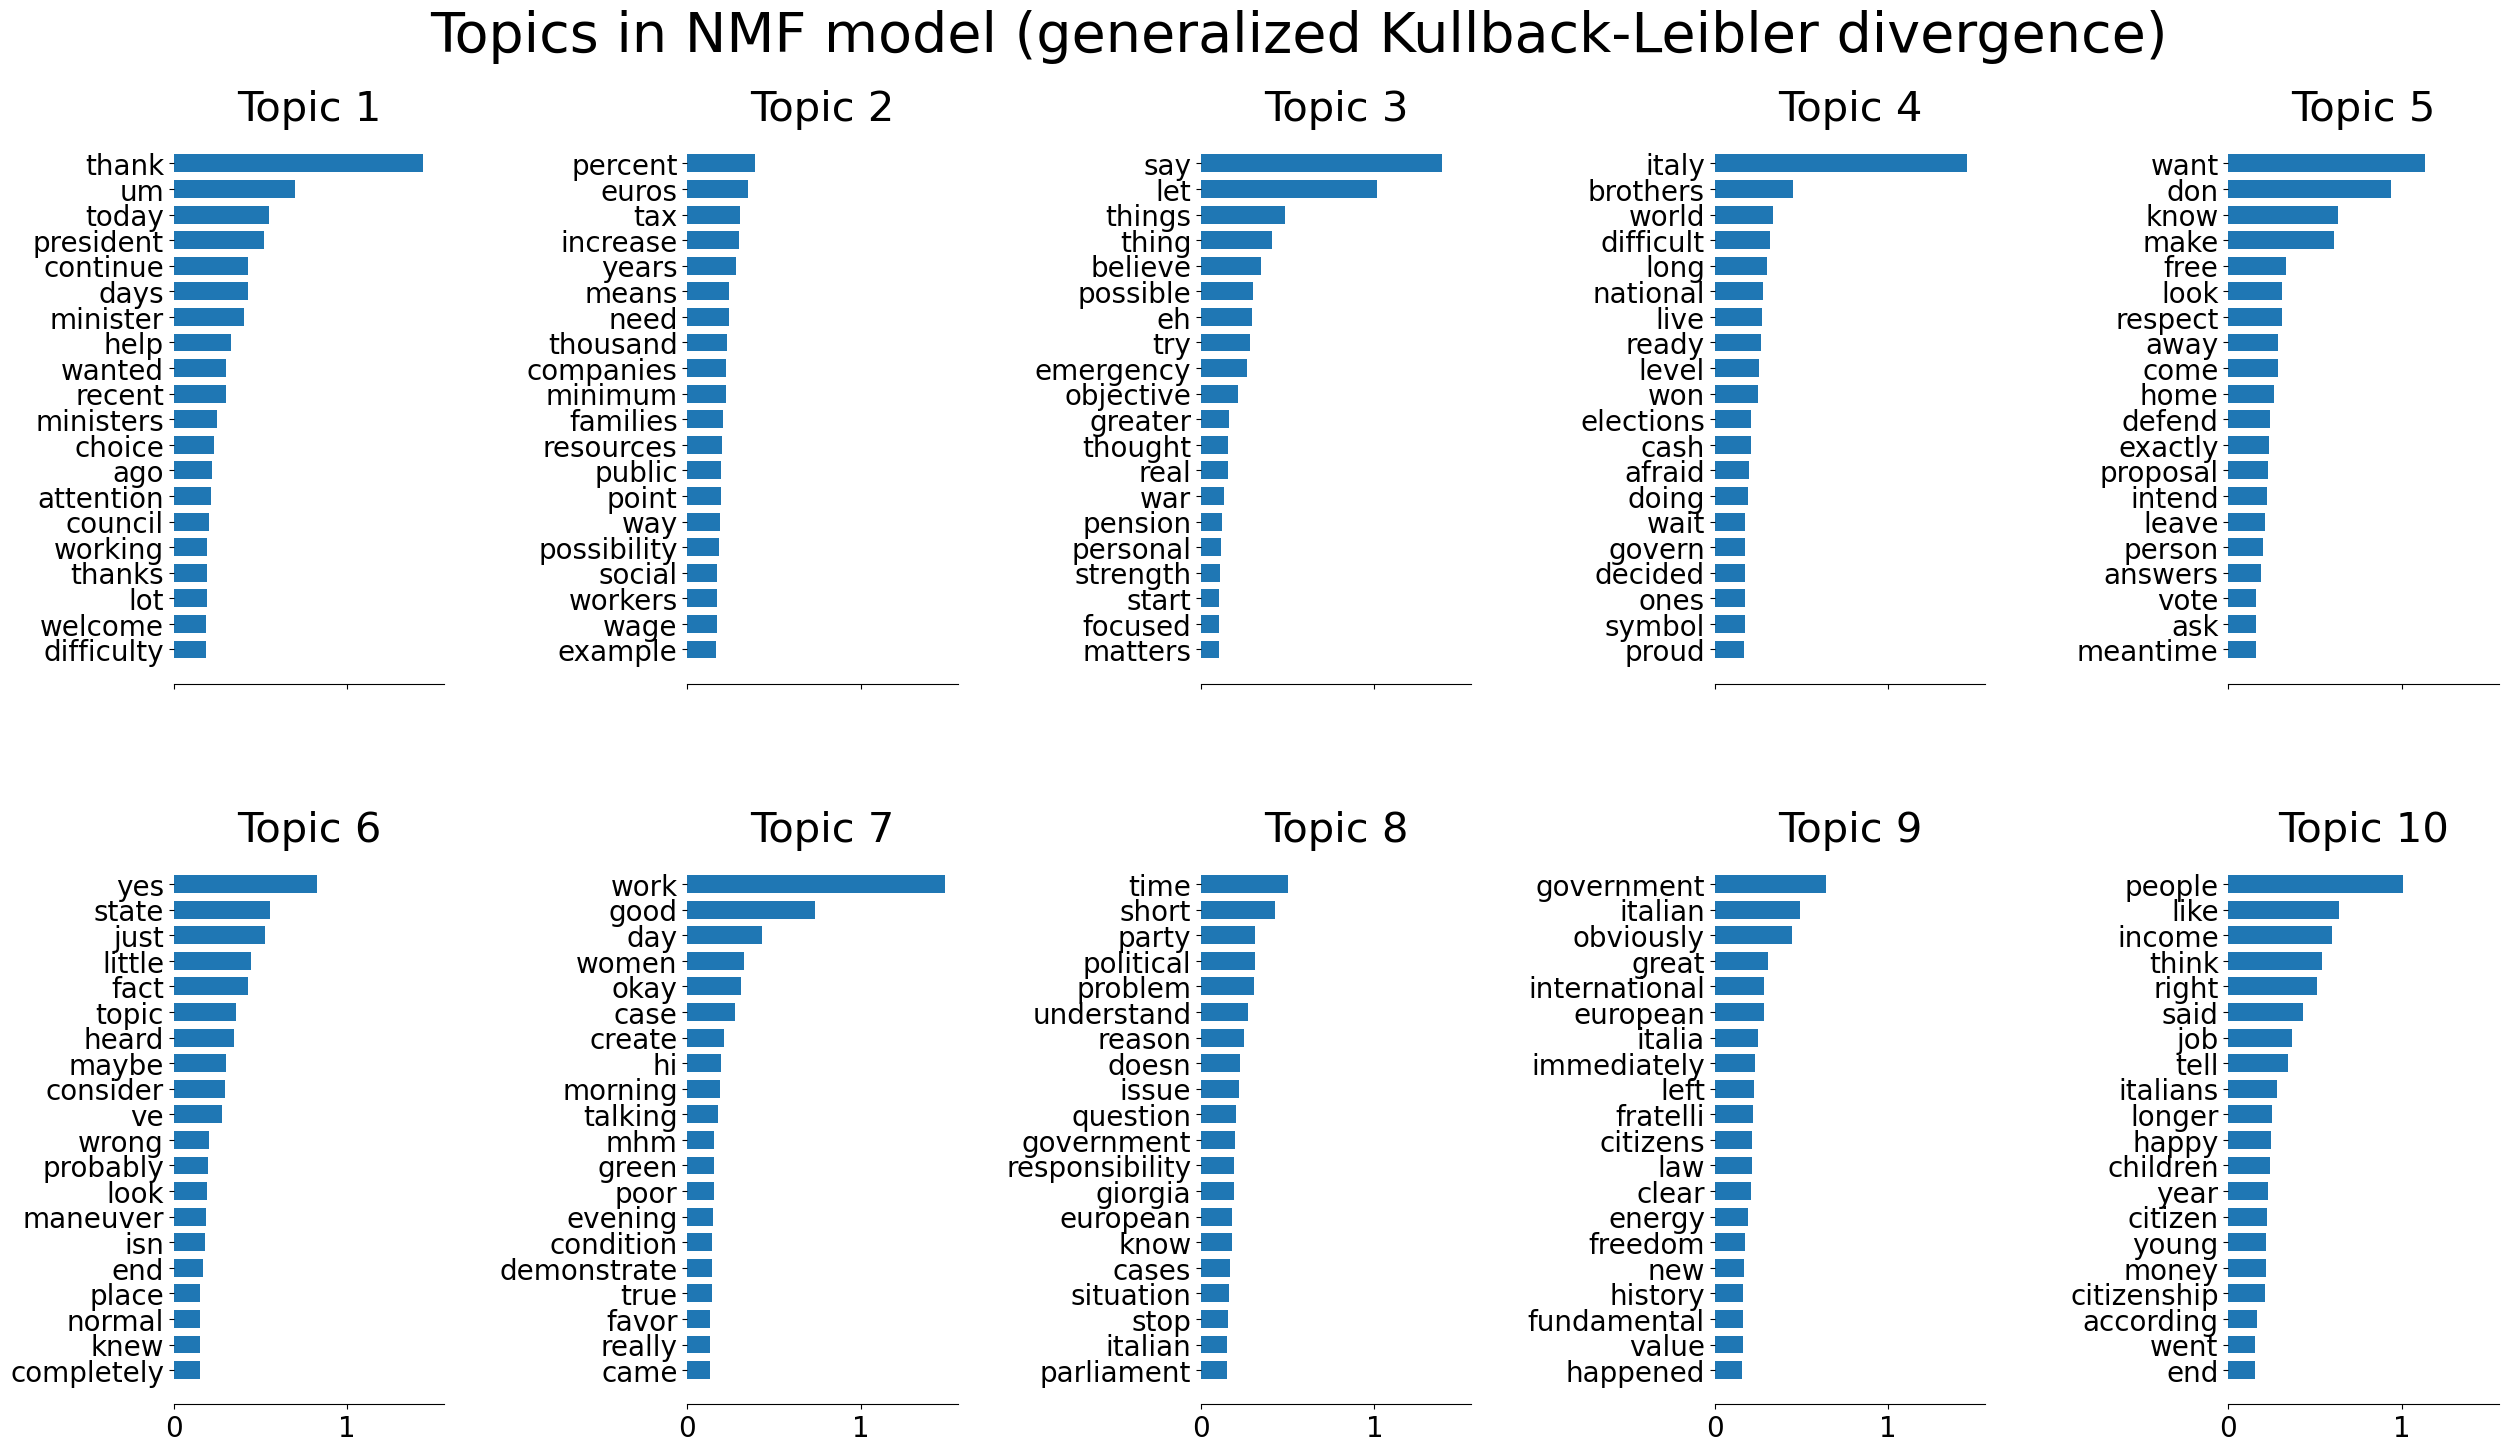



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.308s.


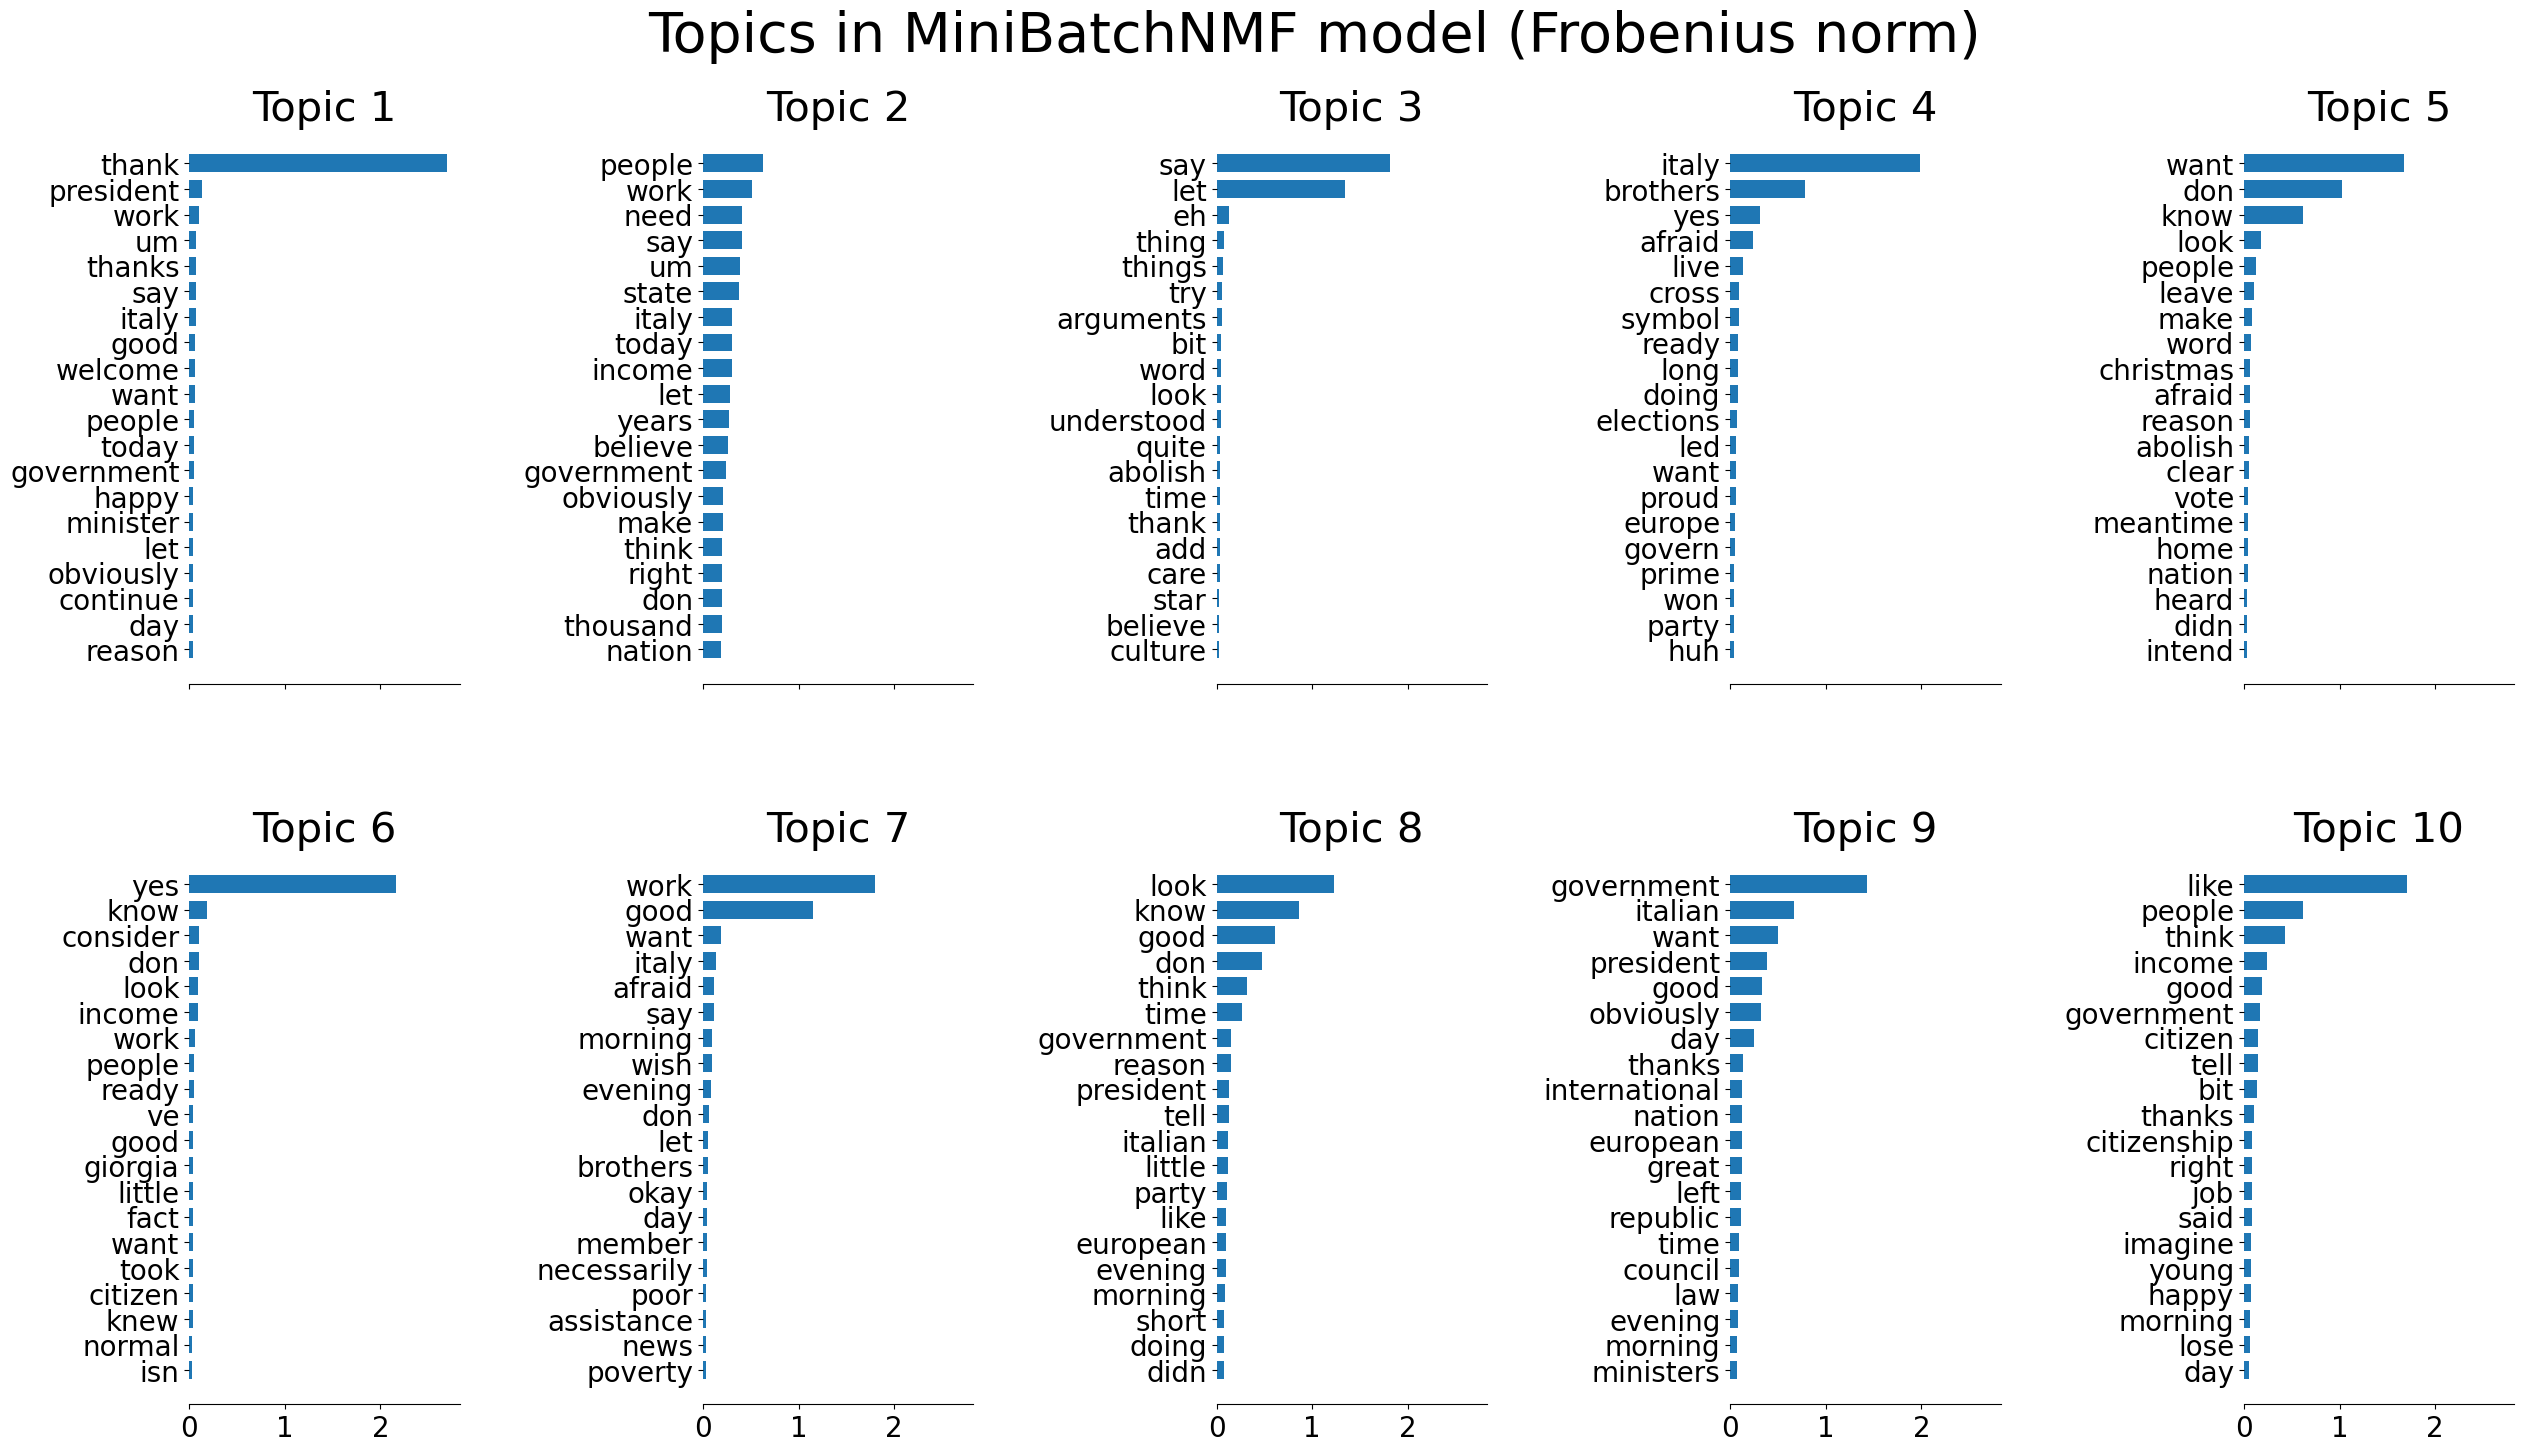



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.444s.


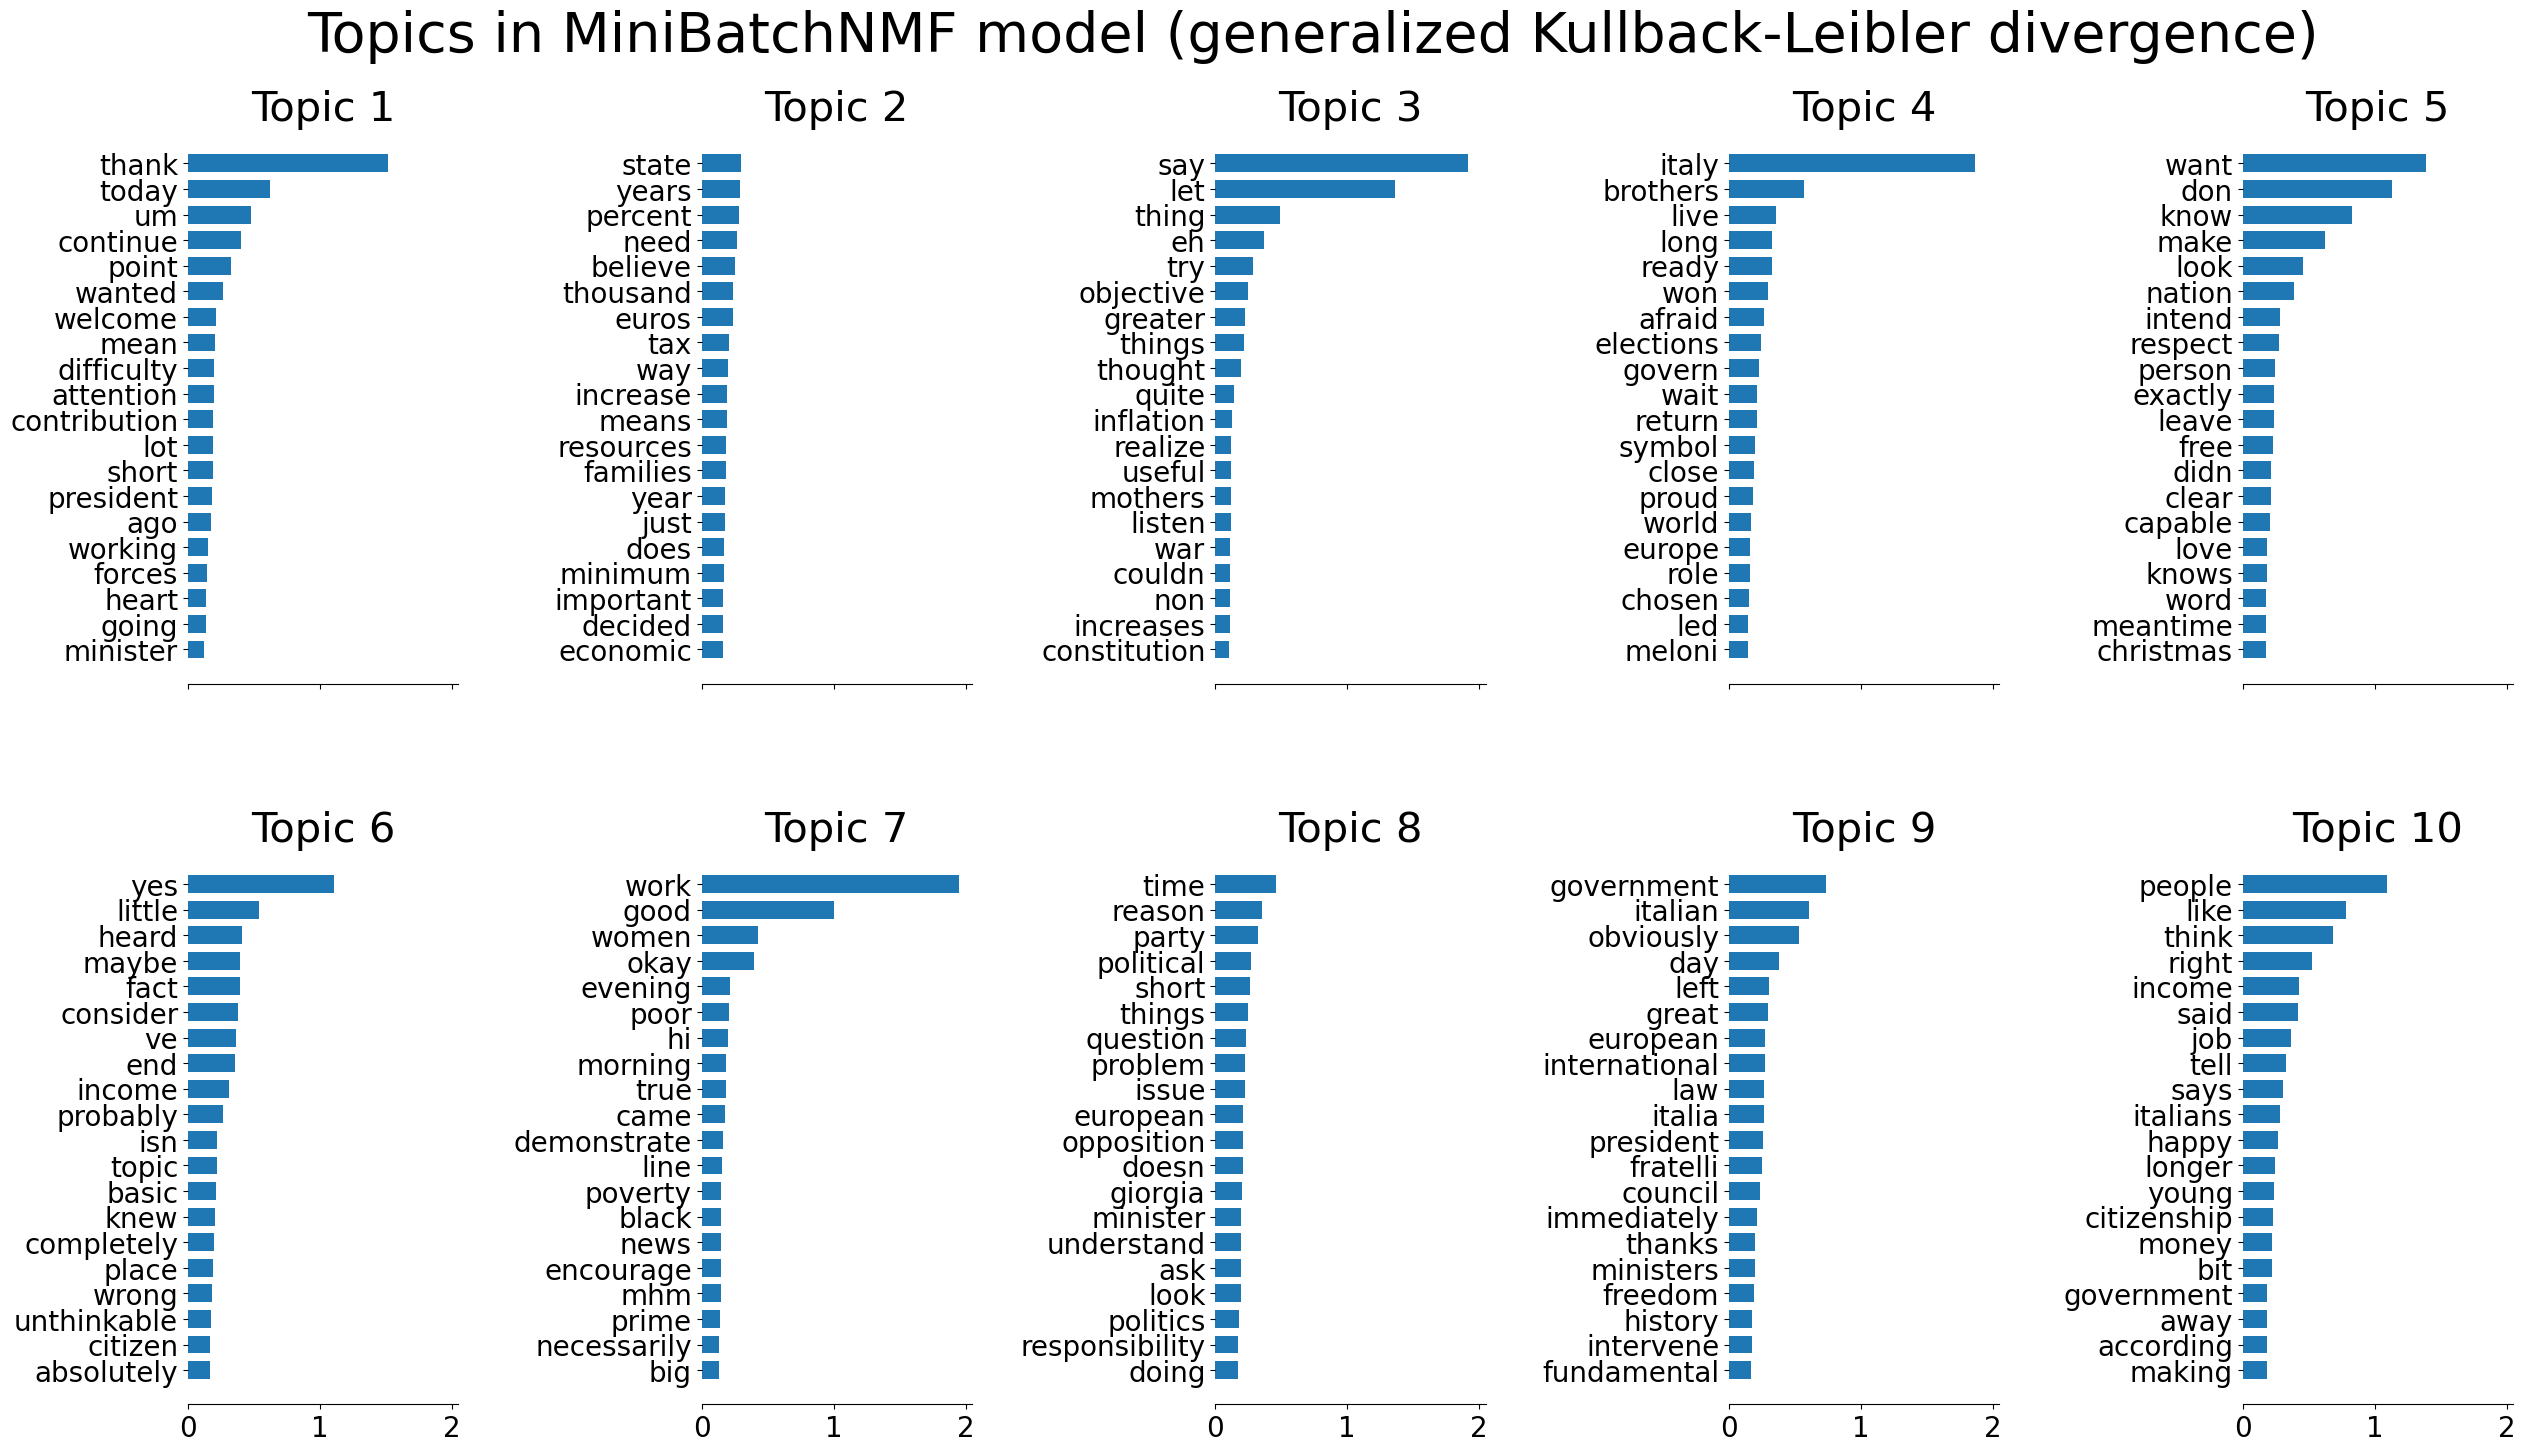



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 0.619s.


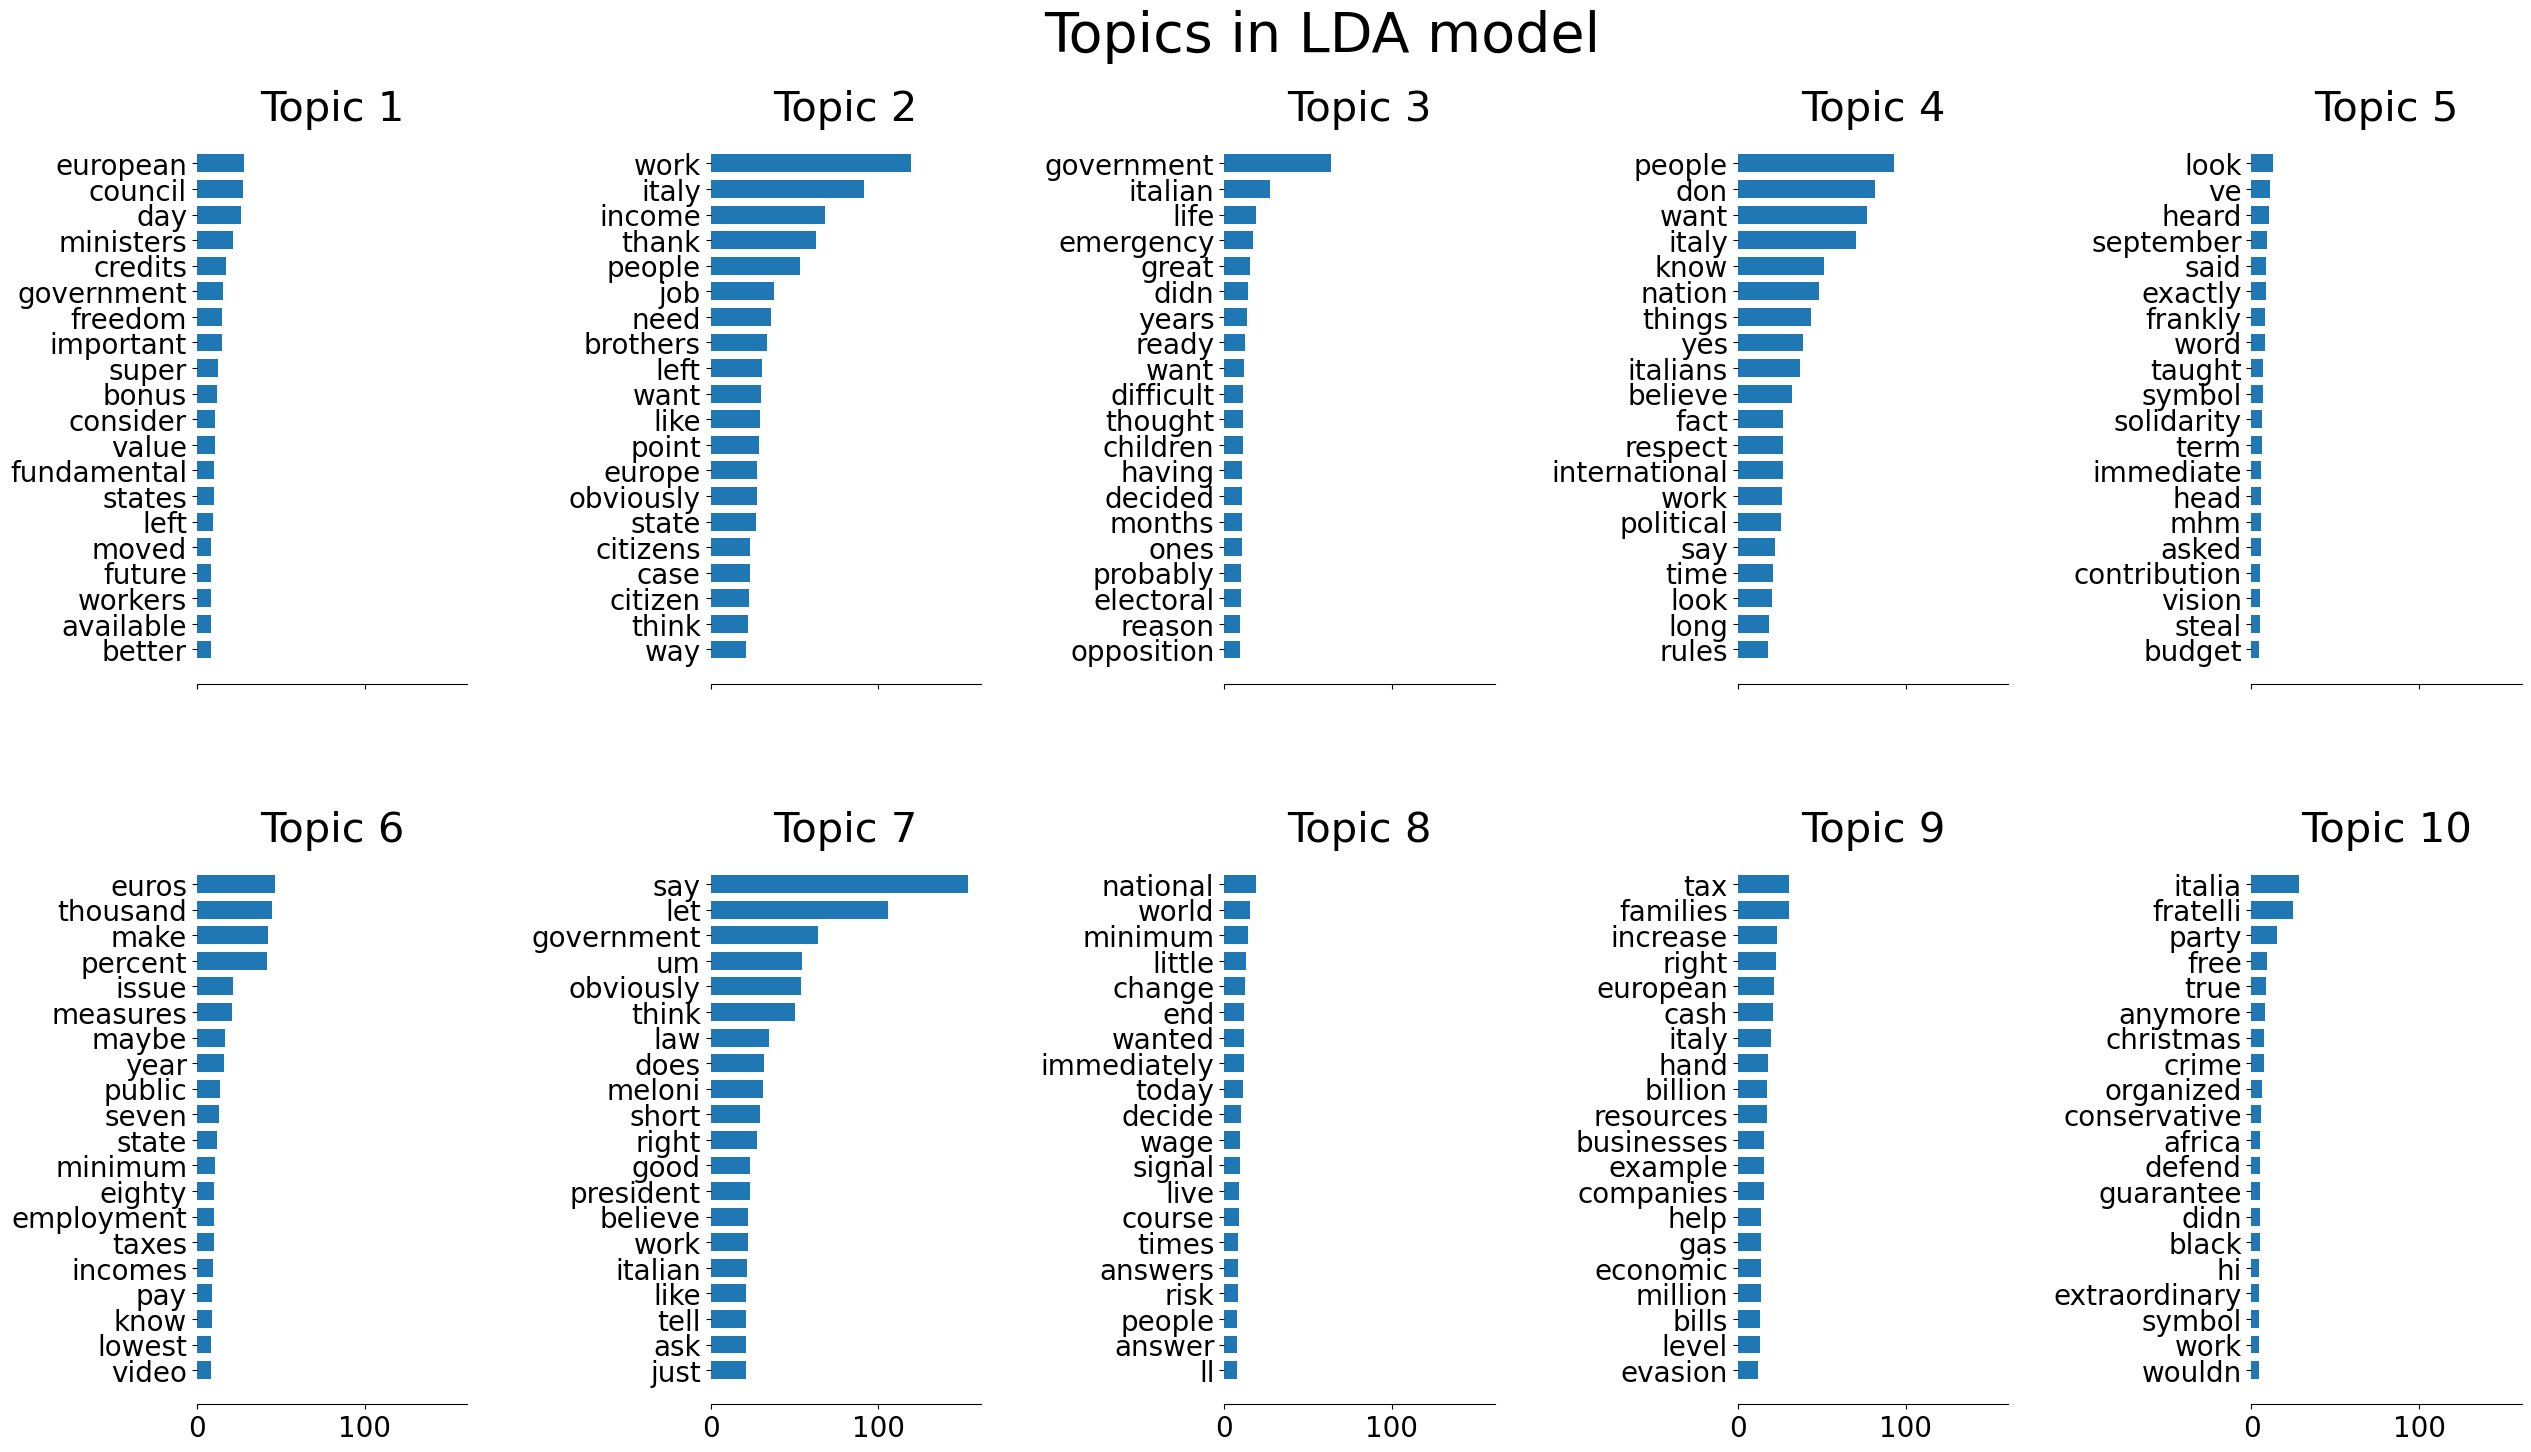

In [33]:
from time import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

print("Loading dataset...")
t0 = time()

data_samples = docs[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")    